<a href="https://colab.research.google.com/github/dhanushka365/LSTM-AutoEncoders/blob/main/LSTM_AUTO_ENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!pip install --prefix {sys.prefix} pandas tensorflow scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Load the sequence data from csv
df = pd.read_csv('/content/drive/MyDrive/hourly_csv/AEP_hourly.csv')

In [5]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [6]:
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()


**Data Time Period**

In [7]:
df['Date'].min(), df['Date'].max()

(datetime.date(2004, 10, 1), datetime.date(2018, 8, 3))

# Visualize the data

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['AEP_MW'], name='AEP_MW'))
fig.update_layout(showlegend=True, title='Electricity usage 2004-2020')
fig.show()

# Data Preprocessing

In [88]:
startdate = pd.to_datetime("2004-12-7").date()
enddate = pd.to_datetime("2018-6-10").date()
train = df.loc[df['Date'] <= startdate]
test = df.loc[df['Date'] > enddate]
train.shape, test.shape

((1630, 8), (1273, 8))

# Data Scaling

In [89]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['AEP_MW']).reshape(-1,1))

train['AEP_MW'] = scaler.transform(np.array(train['AEP_MW']).reshape(-1,1))
test['AEP_MW'] = scaler.transform(np.array(test['AEP_MW']).reshape(-1,1))

<ipython-input-89-d1d7d0b4fca4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-d1d7d0b4fca4>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



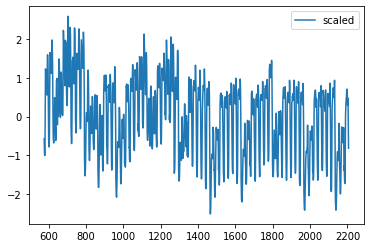

In [90]:
# Visualize scaled data
plt.plot(train['AEP_MW'], label = 'scaled')
plt.legend()
plt.show()

# Create sequences

In [91]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['AEP_MW']], train['AEP_MW'])
X_test, y_test = create_sequences(test[['AEP_MW']], test['AEP_MW'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1600, 30, 1)
Testing input shape:  (1243, 30, 1)


In [92]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

# Build a model

In [97]:
print(X_train.shape[1])

30


In [98]:
print(X_train.shape[2])

1


In [104]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [105]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=500,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 1.0106 - val_loss: 1.0189
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.9953 - val_loss: 1.0315
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.9920 - val_loss: 1.0123
Epoch 4/10
3/3 [==============================] - 3s 909ms/step - loss: 0.9900 - val_loss: 0.9967
Epoch 5/10
3/3 [==============================] - 2s 626ms/step - loss: 0.9902 - val_loss: 0.9899
Epoch 6/10
3/3 [==============================] - 2s 629ms/step - loss: 0.9900 - val_loss: 0.9887
Epoch 7/10
3/3 [==============================] - 2s 667ms/step - loss: 0.9895 - val_loss: 0.9887
Epoch 8/10
3/3 [==============================] - 2s 640ms/step - loss: 0.9892 - val_loss: 0.9857
Epoch 9/10
3/3 [==============================] - 2s 935ms/step - loss: 0.9889 - val_loss: 0.9799
Epoch 10/10
3/3 [==============================] - 3s 1s/step - loss: 0.9888 - val_loss: 0.9764


# Plot Training - Validation loss

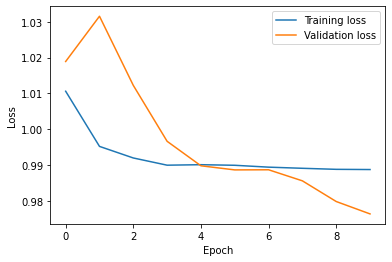

In [106]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

302/302 [==============================] - 14s 43ms/step
Reconstruction error threshold: 1.6279131510303615


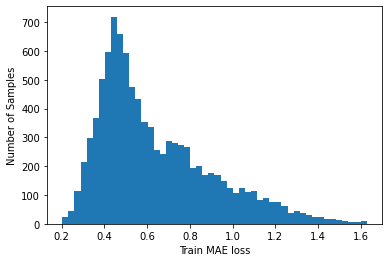

In [80]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# Predict Anomalies on test data using threshold

39/39 [==============================] - 1s 36ms/step


Text(0, 0.5, 'Number of samples')

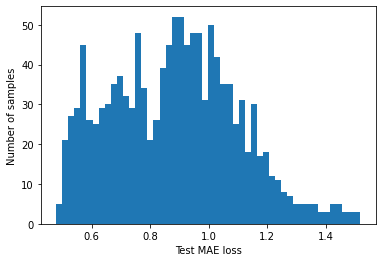

In [81]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [82]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [83]:
anomaly_df.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly
116168,2018-08-01 07:00:00,-0.827743,8,2018,2018-08-01,07:00:00,31,Wednesday,0.887858,1.627913,False
116169,2018-08-01 08:00:00,-0.576957,8,2018,2018-08-01,08:00:00,31,Wednesday,0.884815,1.627913,False
116170,2018-08-01 09:00:00,-0.358568,8,2018,2018-08-01,09:00:00,31,Wednesday,0.864917,1.627913,False
116171,2018-08-01 10:00:00,-0.143380,8,2018,2018-08-01,10:00:00,31,Wednesday,0.834377,1.627913,False
116172,2018-08-01 11:00:00,0.026611,8,2018,2018-08-01,11:00:00,31,Wednesday,0.793979,1.627913,False


In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [68]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day,loss,threshold,anomaly


In [47]:
anomalies.shape

(439, 11)

In [69]:
anomaly_df['AEP_MW'] = scaler.inverse_transform(np.array(anomaly_df['AEP_MW']).reshape(-1,1))
# anomalies['AEP_MW'] = scaler.inverse_transform(np.array(anomalies['AEP_MW']).reshape(-1,1))

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['AEP_MW'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['AEP_MW'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()